# Laboratory 3: Getting started with Pytorch

In this laboratory we will begin working with Pytorch to implement and train complex, nonlinear models for supervised learning problems. You will notice many similarities between Numpy and Pytorch -- this is deliberate, but it can cause some confusion and for many things we will have to convert back and forth between Numpy arrays and Pytorch tensors.

## Part 0: First steps

**Important**: You **must** install Pytorch in your Anaconda environment for this laboratory. The easiest way to do this is to just install the CPU version of Pytorch like this:

```
conda activate FML
conda install -c pytorch pytorch torchvision
```

**Note**: If you have an Nvidia GPU on your computer you can also install the GPU-enabled version of Pytorch which will **greatly** improve performance for more complex models and larger datasets. However, it can be very hard to get all of the versions of the required libraries to match correctly... During the laboratory we can look at it together if you are interested.

After installing Pytorch, use the next cell to verify that the installation is working. If it prints a 3x3 sensor, we're good to go.

In [1]:
# questo codice verica che pytorch sia installato correttamente
import numpy as np
import matplotlib.pyplot as plt
import torch

print(torch.randn((3, 3)))

tensor([[-1.0817,  0.6057,  0.1232],
        [ 1.3793,  0.8221, -1.2393],
        [ 0.0602,  0.3486,  0.9612]])


## Part 1: Dataset preparation

We will work with the venerable MNIST dataset of handwritten digits in this laboratory. The `torchvision` library provides classes for a bunch of standard datasets, including MNIST. These classes automatically download and prepare the dataset for use.

In [2]:
# Download and load the MNIST dataset.
from torchvision.datasets import MNIST

# Load the MNIST training and test splits.
ds_train = MNIST(root='./data', download=True, train=True)
ds_test  = MNIST(root='./data', download=True, train=False)


### Exercise 1.1: Exploratory data analysis

Spend some time inspecting the `ds_train` and `ds_test` data structures in order to get a feel for the data. What is the format? How big are the images? How many are there? What about the range of pixel values? Where are the labels for images?

Remember that one of the best ways to explore is to *visualize*.

In [3]:
print(f'- primo campione del train set: {ds_train[0]}')
print(f'- dimensione del train set: {ds_train.data.shape}')
print(f'- dimensione del test set: {ds_test.data.shape}')
print(f'- numeri che possiamo trovare: {np.unique(ds_train.targets.numpy())}')

- primo campione del train set: (<PIL.Image.Image image mode=L size=28x28 at 0x7F99CD8F4A00>, 5)
- dimensione del train set: torch.Size([60000, 28, 28])
- dimensione del test set: torch.Size([10000, 28, 28])
- numeri che possiamo trovare: [0 1 2 3 4 5 6 7 8 9]


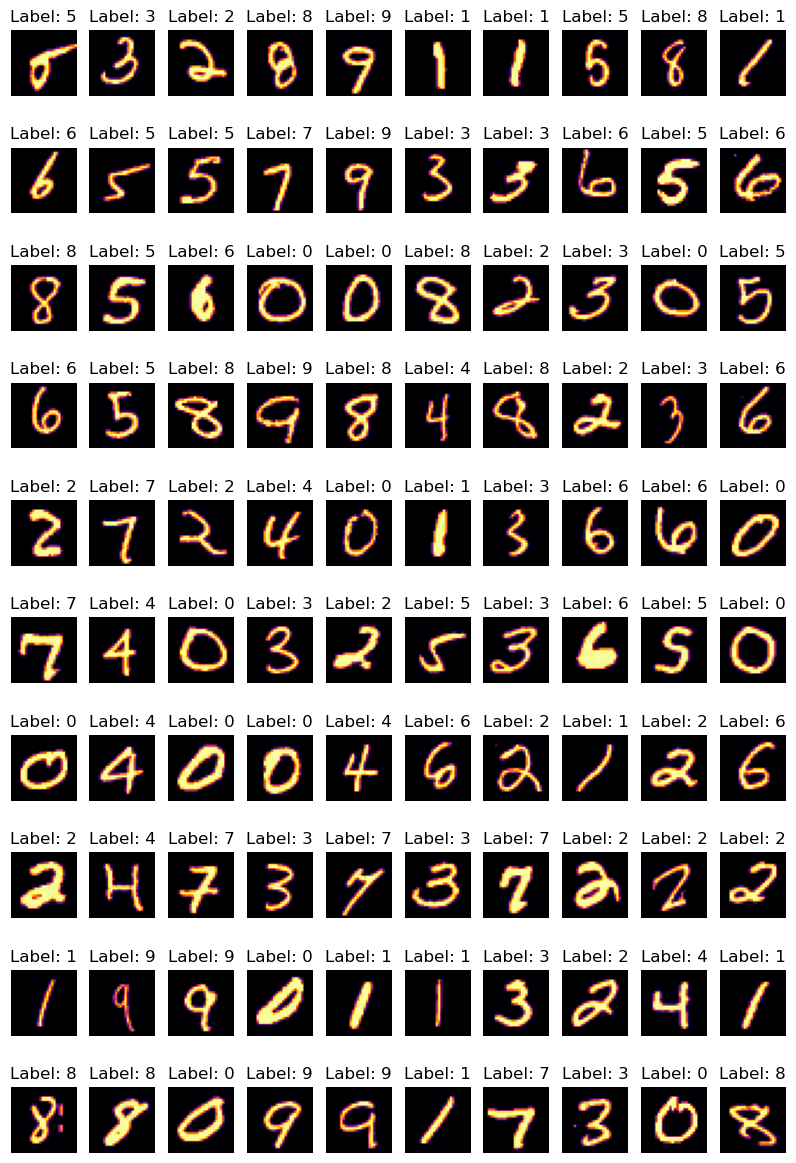

In [4]:
plt.figure(figsize=(10, 15))
I = np.random.permutation(range(len(ds_train.data)))[:100]
for (i, idx) in enumerate(I):
    plt.subplot(10, 10, i+1)
    plt.imshow(ds_train.data[idx], cmap='inferno')
    plt.title(f'Label: {ds_train.targets[idx]}')
    plt.axis('off')

**Analisi**

- Osserviamo le informazioni del primo sample del train (sarebbe lo stesso anche per gli altri e anche usando il test set):
  - *PIL.Image.Image* è la classe che rappresenta un oggetto di tipo immagine.
  - *mode=L* indica che i pixel sono definiti da 8 bit (dove 0 indica il nero e 255 il bianco) e la scala di colori utilizzata è quella dei grigi.
- Si può notare i samples del train set sono 60000 mentre quelli del test set sono 10000. Ognuno dei 70000 sample che compongono il dataset è un quadrato 28x28.
- I target, cioè i numeri rappresentati, vanno da 0 a 9, come ci si aspetterebbe.

Tramite le immagini si riesce bene a capire con cosa stiamo lavorando.

In [5]:
ds_train.data.min(), ds_train.data.max(), len(np.unique(ds_train.data))

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8), 256)

**Analisi**

- `ds_train.data.min()` restituisce il valore minimo presente del train set. Ci aspettiamo (che è quello che otteniamo) che il risultato sia 0, che indica un pixel totalmente nero.
- Per `ds_train.data.max()` il discorso è lo stesso di quanto detto sopra, solo che ci aspettiamo 255, cioè un pizel totalmente bianco.
- `len(np.unique(ds_train.data))` conta il numero di valori unici. Ci aspettiamo che ci siano tutti i valori possibili, cioè 256; nel caso ce ne siano di meno vuol dire che non tutte le intensità di gricio sono presenti nel dataset.

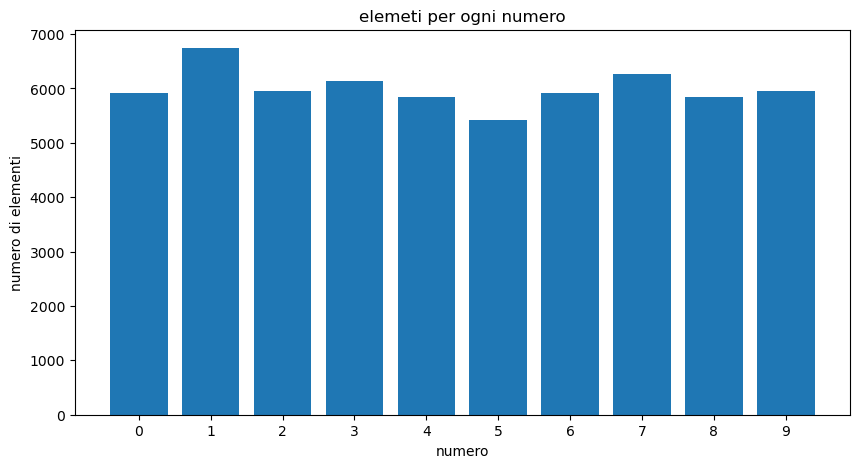

In [6]:
targets = ds_train.targets.numpy()
targets, counts = np.unique(targets, return_counts=True)

plt.figure(figsize=(10, 5))
plt.bar(targets, counts)
plt.xlabel('numero')
plt.ylabel('numero di elementi')
plt.title('elemeti per ogni numero')
plt.xticks(targets)
plt.show()

**Analisi**

Si può osservare che siamo davanti a un problema abbastanza bilanciato, anche se non come nei precedenti laboratori.

### Exercise 1.2: Dataset conversion and normalization

+ **Datatype Conversion**:
The first thing we need to do is convert all data tensors to `torch.float32` -- this is fundamental as it is extremely inconvenient to work with `uint8` data. Using 32-bit floating point numbers is a compromise between precision and space efficiency.
The `torch.Tensor` class has a very useful method `to()` for performing datatype and device (e.g. to GPU) conversions. Check out the [documentation here](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html#torch-tensor-to).

+ **Normalization**:
Next, we need to correct the inconvenient range of [0, 255] for the pixel values. You should *subtract* the mean intensity value and divide by the standard deviation in order to *standardize* our data. **Important**: Think *very carefully* about *which* split you should use to compute the pixel statistics for standardization.

+ **Reshaping**: Is the data in an appropriate format (i.e. shape) for the training the models we know? Think about whether (and how) to fix this if needed.

**What to do**: In the cell below you should perform this sequence preprocessing operations on the `ds_train.data` and `ds_test.data` tensors.

In [7]:
# conversione

Xs_train = ds_train.data.to(torch.float32)
Xs_test = ds_test.data.to(torch.float32)
ys_train = ds_train.targets
ys_test = ds_test.targets

In [8]:
# normalizzazine

mean = Xs_train.mean()
std  = Xs_train.std()
Xs_train = (Xs_train - mean)/std
Xs_test = (Xs_test - mean)/std

print(Xs_train[0:2])

tensor([[[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         ...,
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]],

        [[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         ...,
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
         [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]]])


In [9]:
# reshaping

Xs_train = Xs_train.flatten(1, 2)
Xs_test = Xs_test.flatten(1, 2)
print(f'train: {Xs_train.shape}')
print(f'test: {Xs_test.shape}')

train: torch.Size([60000, 784])
test: torch.Size([10000, 784])


**Analisi**

- Conversione\
  Non trasformiamo i target perché sono valori interi che rappresentano la classe a cui le immagini appartengono.
- Normalizzazione\
  I valori di pixel sono nell'intervallo [0,255]. Normalizzando si restringe i dati all'interno dell'intrvallo [0,1], che è più utile per il modello per l'analisi. La stampa serve per essere sicuri di quanto fatto.
- Reshaping\
  Permette di trasformare la prima e la seconda dimensione di ogni sample in un vettore. In questo modo (come si può vedere dalle informazioni stampate) un campione è un singolo vettore composto da 784 (28x28) pixel.

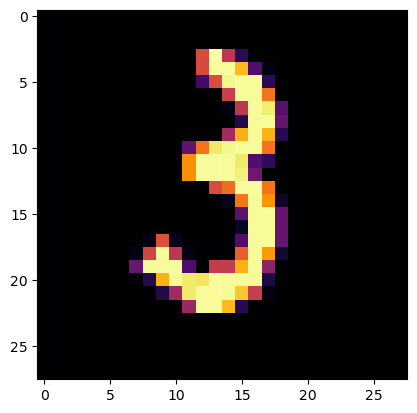

In [10]:
plt.imshow(Xs_train[1234].reshape(28, 28), cmap='inferno')

### Exercise 1.3: Subsampling the MNIST dataset.

MNIST is kind of big, and thus inconvenient to work with unless using the GPU. For this laboratory we will use a smaller subset of the dataset for training to keep memory and computation times low.

Modify `ds.train` to use only a subset of, say, 10000 images sampled from the original data. Make sure to select the correct corresponding targets.


In [11]:
train_size = 10000

I = np.random.permutation(range(len(Xs_train)))[:train_size]
Xs_train_ss = Xs_train[I]
ys_train_ss = ys_train[I]

## Establishing a stable baseline

In this exercise you will establish a reliable baseline using a classical approach. This is an important step in our methodology in order to judge whether our Deep MLP is performing well or not.

### Exercise 2.1: Establish the stable baseline

Train and test your stable baseline to estimate the best achievable accuracy using classical models.

**Tip**: Don't do any extensive cross-validation of your baseline (for now). Just fit a simple model (e.g. a linear SVM) and record the accuracy.



In [12]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

svc = LinearSVC()
svc.fit(Xs_train_ss, ys_train_ss)
preds = svc.predict(Xs_test)
print(classification_report(ys_test, preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       980
           1       0.93      0.97      0.95      1135
           2       0.88      0.83      0.85      1032
           3       0.84      0.86      0.85      1010
           4       0.85      0.90      0.88       982
           5       0.85      0.77      0.81       892
           6       0.89      0.92      0.91       958
           7       0.86      0.90      0.88      1028
           8       0.82      0.77      0.80       974
           9       0.83      0.81      0.82      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


**Analisi**

Tramite le informazioni ottenute da `LinearSVC` potremmo confrontare i modelli che costruiremo tra poco.

Non aumentiamo il numero di iterazioni per far convergere il modello perché richiederebbe veramente troppo tempo.

## Part 3: Training some deep models (finally)

Now we will finally train some deep models (Multilayer Perceptrons, to be precise). Since the dataset is a bit too large to use batch gradient descent, we will first need to setup a `torch.utils.data.DataLoader` for our training data. A `DataLoader` breaks the dataset up into a sequence of *batches* that will be used for training. In order to use this, we will first have to use `torch.utils.data.TensorDataset` on `ds_train.data` and `ds_train.targets` to make a new torch `dataset` for use in the dataloader.

### Exercise 3.1: Creating the DataLoader

Create a `DataLoader` for `ds_train` use a `batch_size` of about 16 or 32 to start. After you have your `DataLoader` experiment with is using `next(iter(dl_train))` to see what it returns. The pytorch `DataLoader` is a Python iterator.

**EXTREMELY IMPORTANT**: Make sure you use `shuffle=True` in the constructor of your dataloader.

In [13]:
from torch.utils.data import DataLoader, TensorDataset

ds = TensorDataset(Xs_train_ss, ys_train_ss)
for size in [16, 32, 100]:
    dl_train = DataLoader(ds, batch_size=size, shuffle=True)
    print(f'- Numero di batch per size={size}: {len(dl_train)}')

- Numero di batch per size=16: 625
- Numero di batch per size=32: 313
- Numero di batch per size=100: 100


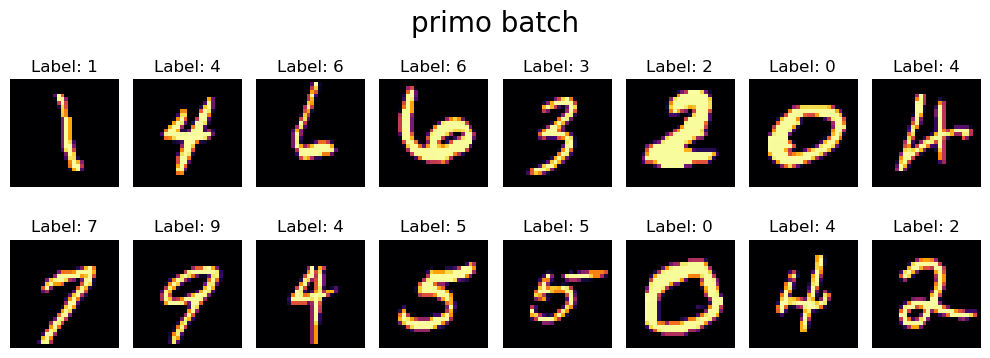

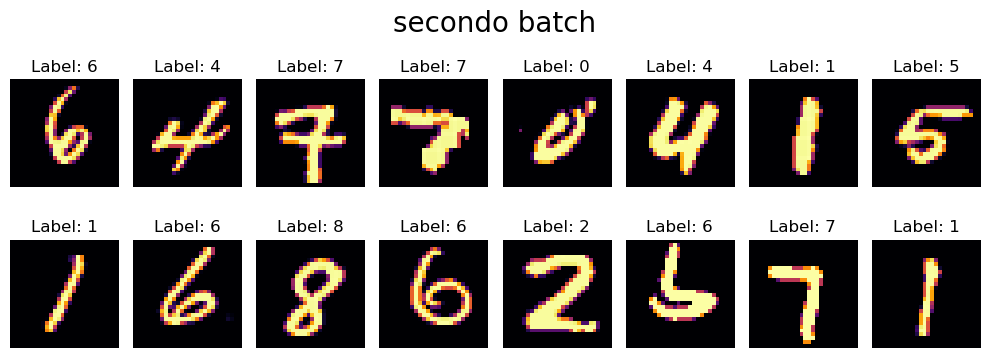

In [14]:
dl_train = DataLoader(ds, batch_size=16, shuffle=True)

# primo batch
data1, target1 = next(iter(dl_train))
fig1, axes1 = plt.subplots(2, 8, figsize=(10, 4))
axes1 = axes1.flatten()

for i in range(len(data1)):
    image = data1[i].reshape(28, 28).numpy()
    label = target1[i].item()
    axes1[i].imshow(image, cmap="inferno")
    axes1[i].set_title(f'Label: {label}')
    axes1[i].axis('off')

fig1.suptitle('primo batch', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
print('\n')

# secondo batch
data2, target2 = next(iter(dl_train))
fig2, axes2 = plt.subplots(2, 8, figsize=(10, 4))
axes2 = axes2.flatten()

for i in range(len(data2)):
    image = data2[i].reshape(28, 28).numpy()
    label = target2[i].item()
    axes2[i].imshow(image, cmap="inferno")
    axes2[i].set_title(f'Label: {label}')
    axes2[i].axis('off')

fig2.suptitle('secondo batch', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


**Analisi**

Un DataLoader è una calsse che permette di caricare i dati in modo efficiente e di gestire i batch durante l'addestramento del modello quando il dataset è troppo grande per essere caricato in memoria contemporaneamente.
- `len(dl_train)` restituisce il numero di batch di cui è comporto il DataLoader. Osserviamo infatti che costruendo più DataLoader con batch di size diverse il numero di batch cambia; queste costruzioni sono fatte solo per mostrare questo concetto, alla fine si costruire il DataLoader usato.
- `next(iter(dl_train))` restituisce un batch di dati delle dimensioni specificate. Per notare come i batch siano diversi sono stati stampati due batch con *size=16*. Non ho stampato batch di size più grossa per comodità.

Ho costruito più DataLoader per mostrare e capire il comportamento. All'inzio dell'esercizio 3.2 sarà usato ancora l'ultimo di questi; nel secondo punto invece sarà creato il dataLoader utilizzato (che poi sarà cambiato per vedere come cambia il comportamento).

### Some support code (NOT an exercise).

Here is some support code that you can use to train a model for a **single** epoch. The function returns the mean loss over all iterations. You will use it in the next exercise to train and monitor training.

In [15]:
# Train a model for a single epoch. You should pass it a model, a dataloader,
# and an optimizer. Returns the mean loss over the entire epoch.

def train_epoch(model, dl, optimizer):
    model.train()
    losses = []
    for (xs, ys) in dl:
        optimizer.zero_grad()
        output = model(xs) #forward passa to compute output.
        loss = torch.nn.functional.nll_loss(output, ys) # compute the negative log likeliwooh loss.
        loss.backward() # compute gradient.
        optimizer.step() # tell the optimazer to perform a gradient step.
        losses.append(loss.item())
    model.eval()
    return np.mean(losses)

### Exercise 3.2: Defining a 1-layer neural network

Define a simple model that uses a **single** `torch.nn.Linear` layer followed by a `torch.nn.Softmax` to predict  the output probabilities for the ten classes.

In [16]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(784, 10),
    nn.LogSoftmax(dim=1)
)

(Xs, ys) = next(iter(dl_train))
prob = model(Xs)
print(prob)

tensor([[-3.5513, -2.7469, -3.2945, -2.2247, -1.2287, -2.3509, -1.9161, -2.7537,
         -2.7016, -2.3426],
        [-2.6418, -3.1899, -3.3802, -2.8346, -2.1934, -1.9122, -1.6444, -2.8049,
         -1.5306, -2.7261],
        [-3.0592, -2.1123, -4.0143, -2.2852, -1.6384, -2.4986, -2.4512, -2.9101,
         -2.2968, -1.6369],
        [-2.3400, -3.4333, -4.5195, -1.6822, -2.3434, -2.8852, -1.6733, -2.4931,
         -1.7316, -2.5849],
        [-2.4945, -2.5142, -3.4872, -2.2097, -1.6064, -2.8733, -1.9757, -2.1683,
         -2.4724, -2.2860],
        [-3.3991, -2.8240, -3.7640, -2.0154, -2.3032, -1.6073, -1.8786, -3.0011,
         -1.6819, -2.7830],
        [-2.8618, -1.6632, -3.2349, -1.7479, -2.1302, -1.9516, -2.0215, -3.0825,
         -2.7762, -3.2603],
        [-2.7022, -2.4101, -3.2082, -2.8415, -2.0556, -2.6825, -1.5238, -3.0441,
         -1.9586, -1.9563],
        [-2.3149, -1.8342, -3.8203, -2.7485, -1.7301, -3.7233, -4.1329, -2.3305,
         -2.0038, -1.5799],
        [-2.0600, -

**Analisi**

Si costruisce un modello con un solo layer lineare che prende in input 784 valori (il numero dei pixel di ogni sample) e restitusice un output di dimensione 10 (il numero delle classi possibili). Il risultato sarà la probabilità che il sample appartenga ad ogni classe.

Abbiamo usato `LogSoftmax()` perché la loss function definita in `train_epoch()` è `nll_loss`, cioé (come si legge nella [documentazione](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html)) la log likelihood loss. Nel caso la loss function non sia basata sul logaritmo si sarebbe usata `Softmax()`.

### Exercise 3.2: Training our model

Instantiate a `torch.optim.SGD` optimizer using `model.parameters()` and the learning rate (**tip**: make the learning rate a variable you can easily change). Then run `train_epoch` for a set number of epochs (e.g. 100, make this a variable too). Is your model learning? How can you tell?

In [17]:
dl_train = DataLoader(ds, batch_size=32, shuffle=True)

In [18]:
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

def my_confusion_matrix(ys_true, ys_pred):
    cm = confusion_matrix(ys_true, ys_pred, normalize='true')
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="inferno", xticklabels=targets, yticklabels=targets)
    plt.xlabel('PREDICTED')
    plt.ylabel('TRUE')
    plt.title('Matrice di confusione')
    plt.show()

def model_single_layer(lr=1e-3, batch_size='', epoche=100, conf_matrix=False):

    model = nn.Sequential(
        nn.Linear(784, 10),
        nn.LogSoftmax(dim=1)
    )
    losses = []
    opt = torch.optim.SGD(model.parameters(), lr=lr)

    for epoca in tqdm(range(epoche)):
        losses.append(train_epoch(model, dl_train, opt))

    plt.xlabel("epoche")
    plt.ylabel("perdita")
    plt.title(f'Epoche={epoche}, Learning rate={lr}{batch_size}, Perdita={round(losses[-1], 4)}')
    plt.grid()
    plt.plot(losses)
    plt.show()

    preds = torch.argmax(model(Xs_test), dim=1)
    print(classification_report(ys_test, preds))

    if(conf_matrix==True):
        my_confusion_matrix(ys_test, preds)

**Analisi**

Analiziamo come la modifica del *learning rate* e del *numero di epoche* possa cambiare cambiare l'addestramento di un modello(fonti chatGPT e un [articolo](https://www.andreaprovino.it/how-to-set-learning-rate-deep-learning-neural-networks)).
- Learning rate\
  Con un learning rate basso il modello farà passi piccoli ad ogni iterazione; questo potrebbe rendere il processo più lento, ma potrebbe portare anche ad una migliore convergenza.\
  Impostare un learning rate alto infatti potrebbe non portare alla soluzione ottima; si potrebbe osservare infatti dei salti o un andamento non regolare nella curva della perdita.
- Numero di epoche\
  Con un numero maggiore di epoche il modello avrà più tempo per imparare dai dati. Se il numero di epoche è troppo alto però si potrebbe andare in contro ad overfitting; il modello diventa troppo preciso sui dati di training e non generalizza bene su nuovi dati.\
  Con un numero di epoche basso invece il modello potrebbe non avere abbastanza tempo per convergere verso la soluzione ottima.

  0%|          | 0/100 [00:00<?, ?it/s]

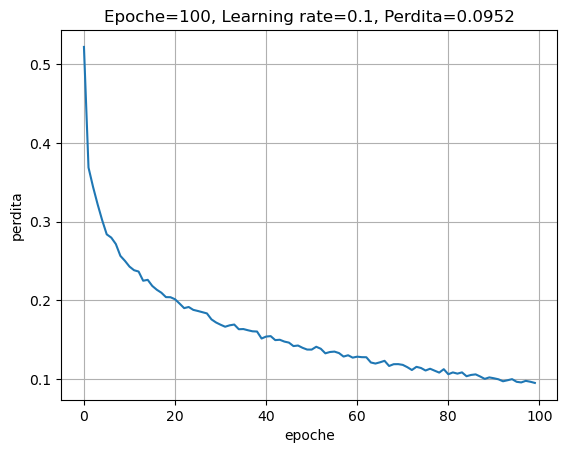

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       980
           1       0.95      0.97      0.96      1135
           2       0.88      0.87      0.88      1032
           3       0.88      0.85      0.87      1010
           4       0.88      0.91      0.90       982
           5       0.83      0.80      0.82       892
           6       0.93      0.92      0.92       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.81      0.82       974
           9       0.84      0.88      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



  0%|          | 0/100 [00:00<?, ?it/s]

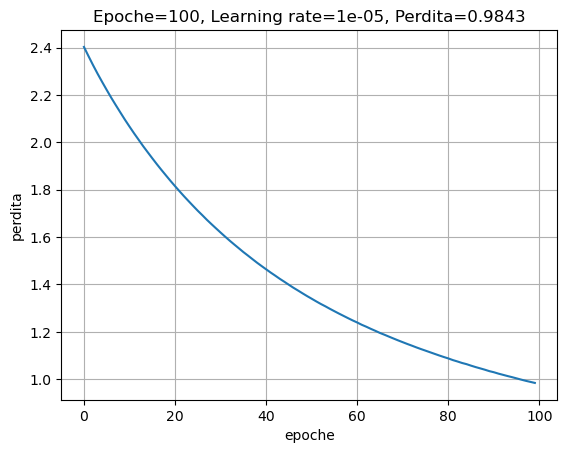

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       980
           1       0.80      0.98      0.88      1135
           2       0.87      0.76      0.81      1032
           3       0.72      0.85      0.78      1010
           4       0.76      0.76      0.76       982
           5       0.83      0.51      0.63       892
           6       0.85      0.89      0.87       958
           7       0.82      0.86      0.84      1028
           8       0.79      0.67      0.73       974
           9       0.69      0.69      0.69      1009

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



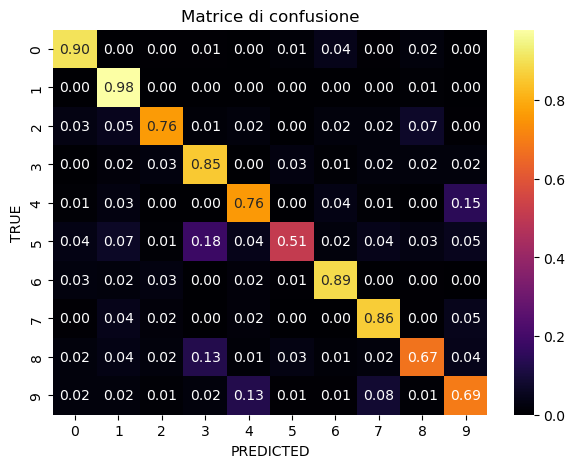

In [19]:
model_single_layer(lr=1e-1)
model_single_layer(lr=1e-5, conf_matrix=True)

**Analisi**

Tenendo fisso il valore delle opche a 100 ho impostato il learning rate prima molto alto (*1e-1*) e poi molto basso (*1e-5*); si può osservare quanto descritto in precedenza:
- Nel primo caso nel grafico ci sono diverse irregolarità. Si arriva però ad una soluzione più precisa e a una accuracy migliore. Questo è duvuto ad una convergenza meno regolare ma più veloce.
- Nel secondo caso invece si ha un grafico molto regolare. La soluzione però è meno precisa e l'accuracy è più bassa del caso precedente. Questo è indice del fatto che con un learning rate basso servono molte più epoche, ma si ha un processo più stabile; questo è confermato anche dal fatto che curva di discesa è più ripida nel secondo caso.

Probabilmente la soluzione migliore è mantenere un buon compromesso (un valore basso ma non troppo), in modo da avere un processo più stabile e non troppo lento.\
Nel seguito sarà considetato *lr=1e-3*.

  0%|          | 0/100 [00:00<?, ?it/s]

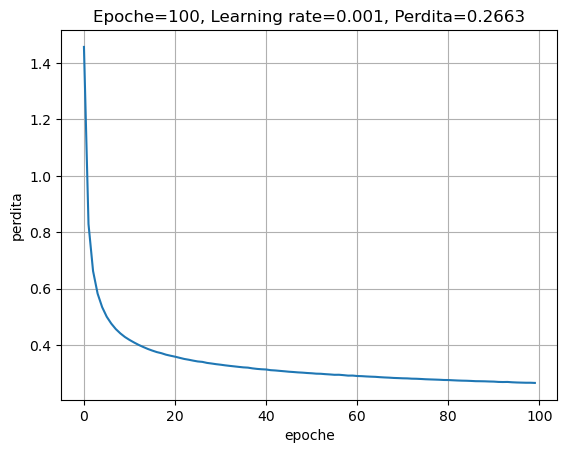

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.95      0.98      0.96      1135
           2       0.92      0.89      0.90      1032
           3       0.89      0.90      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.87      0.86      0.86       892
           6       0.93      0.94      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.89      0.84      0.86       974
           9       0.90      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



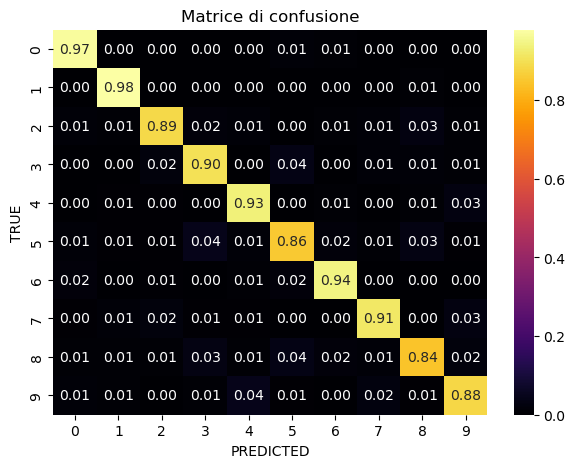

  0%|          | 0/300 [00:00<?, ?it/s]

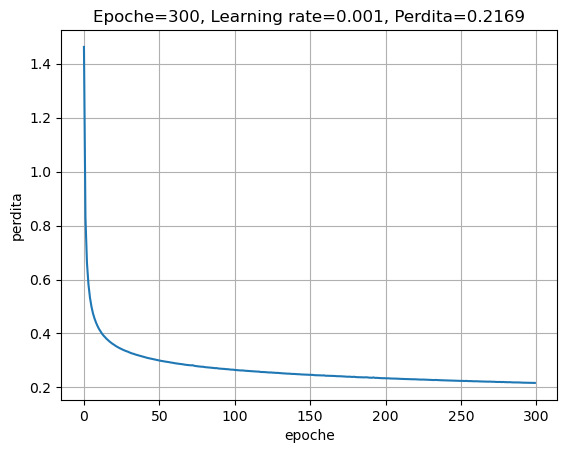

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.92      0.89      0.91      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.93      0.92       982
           5       0.87      0.86      0.86       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91      0.92      1028
           8       0.88      0.86      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [20]:
model_single_layer(conf_matrix=True)
model_single_layer(epoche=300)

**Analisi**

Tenendo fisso il learning rate ho impostato il il numero di epoche prima a *100* e poi a *300*: la soluzione diventa sempre più precisa via via che si aumenta il numero delle epoche.\
È interessante però osservare come l'accuracy invece non migliori.

  0%|          | 0/200 [00:00<?, ?it/s]

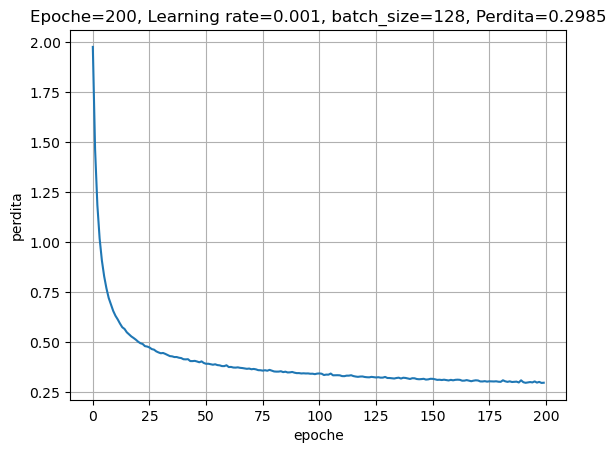

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.94      0.98      0.96      1135
           2       0.92      0.88      0.90      1032
           3       0.89      0.89      0.89      1010
           4       0.89      0.93      0.91       982
           5       0.87      0.85      0.86       892
           6       0.93      0.94      0.94       958
           7       0.92      0.91      0.91      1028
           8       0.87      0.84      0.86       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



  0%|          | 0/200 [00:00<?, ?it/s]

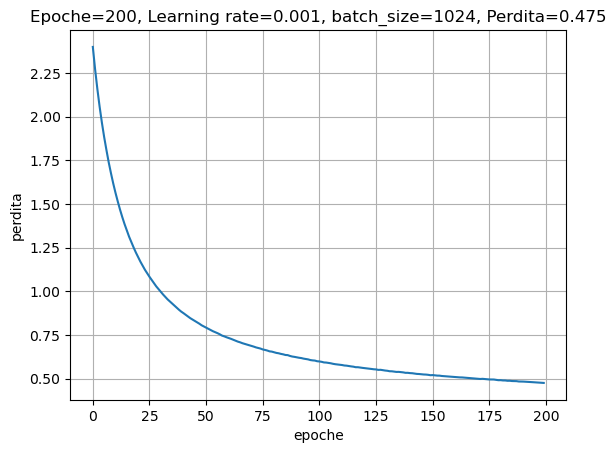

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       980
           1       0.91      0.96      0.94      1135
           2       0.90      0.84      0.87      1032
           3       0.87      0.86      0.87      1010
           4       0.86      0.90      0.88       982
           5       0.84      0.80      0.82       892
           6       0.90      0.92      0.91       958
           7       0.90      0.89      0.89      1028
           8       0.85      0.82      0.84       974
           9       0.84      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



  0%|          | 0/200 [00:00<?, ?it/s]

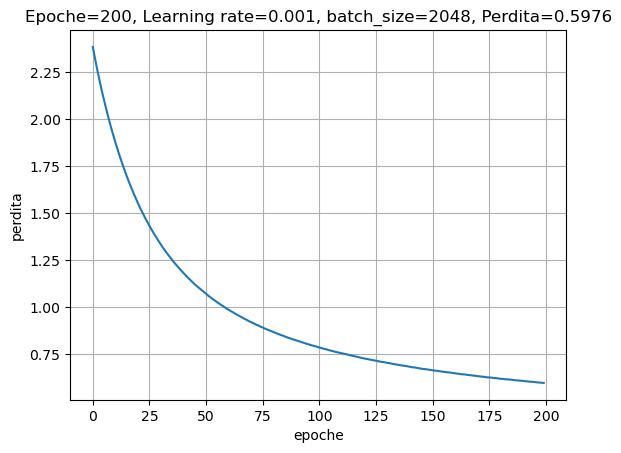

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1       0.88      0.96      0.92      1135
           2       0.88      0.81      0.84      1032
           3       0.85      0.87      0.86      1010
           4       0.83      0.87      0.85       982
           5       0.84      0.73      0.78       892
           6       0.88      0.91      0.89       958
           7       0.89      0.87      0.88      1028
           8       0.84      0.79      0.82       974
           9       0.82      0.84      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [21]:
dl_train = DataLoader(ds, batch_size=128, shuffle=True)
model_single_layer(epoche=200, batch_size=', batch_size=128')

dl_train = DataLoader(ds, batch_size=1024, shuffle=True)
model_single_layer(epoche=200, batch_size=', batch_size=1024')

dl_train = DataLoader(ds, batch_size=2048, shuffle=True)
model_single_layer(epoche=200, batch_size=', batch_size=2048')

**Analisi**

Valutiamo ora come cambia il comportamento del modello al variare della grandezza del batch; ho mantenuto costanti il learning rate a *1e-3* e il numero di epoche a *200*. Ovviamente ogni `dl_train` sarà diverso, ma quello che ci interessa è il concetto: eseguendo lo stesso codice più volte ho ottenuto perdite finali diverse ma dello stesso ordine; la loro differenza è quindi trascurabile per questo contesto.

Si può osservare che prendendo batch di dimensione più piccola si hanno oscillazioni più visibili nel grafico, ma si arriva anche a una perdita minore e a una accuracy più alta.\
Questo può essere causato dal rumore introdotto dai batch di dimensioni inferiori, i quali portano a un processo meno stabile ma che converge più velocemente.

**Analisi**

In tutti i casi sopra descritti si può osservare come il modello stia ancora imparando. Infatti la curva della loss non raggiunge un asintoto orizzontale, ma continua a scendere (in alcuni casi più rapidamente, in altri meno rapidamente).

A posteriori, cioè dopo aver analizzato le milgiori e le peggiori accuracy, ho rieseguito e prodotto le matrici di confusione solo per questi due (migliore e peggiore) in modo da avere una visualizzazione degli errori.\
Osserviamo che l'accuracy massima raggiunta è 0,91.

### Exercise 3.3: Evaluating our model

Write some code to plot the loss curve for your training run and evaluate the performance of your model on the test data. Play with the hyperparameters (e.g. learning rate) to try to get the best performance on the test set. Can you beat the stable baseline?

**Analisi**

Per comodità di avere le variabili tutte nello stesso posto, questo esercizio è stato unito al precedente.

In generale possiamo affermare che l'accuracy migliore che abbiamo ottenuto è 0,91. Ovviamente questo risultato non è sempre vero, a volte si ottiene un'accuracy di 0,92; in ogni i caso la relazione tra i vari modelli e l'analisi è sempre la stessa.

  0%|          | 0/1000 [00:00<?, ?it/s]

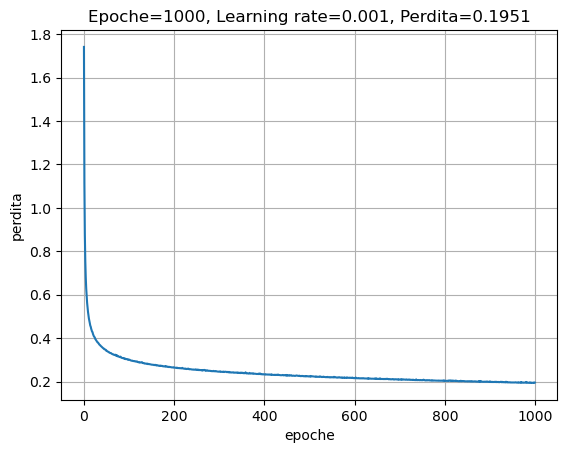

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       980
           1       0.95      0.97      0.96      1135
           2       0.92      0.89      0.90      1032
           3       0.89      0.89      0.89      1010
           4       0.90      0.92      0.91       982
           5       0.87      0.86      0.86       892
           6       0.94      0.95      0.94       958
           7       0.92      0.91      0.91      1028
           8       0.88      0.85      0.86       974
           9       0.89      0.88      0.89      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [22]:
dl_train = DataLoader(ds, batch_size=64, shuffle=True)
model_single_layer(epoche=1000)

**Analisi**

Per curiosità e per vedere come si possono migliorare le cose, ho provato ad eseguire 1000 epoche (non di più a causa del tempo necessario per l'esecuzione) con i gli iperparametri più appropriati: ho deciso un learning rate pari a *1e-3* e una grandezza dei batch di *64*. I risultati sono stati:
- L'accuracy non è più alta della migliore ottenuta fino a questo momento.
- La rapidità nella discesa della curva è minore, ma nonostante questo il modello sta ancora imparando.

Probabilmente aumentare ancora le iterazioni porterebbe ad una perdita leggermente inferiore; mi aspetto invece che si sia raggiunto un limite nell'accuracy.

## Going Deeper

Now we will go (at least one layer) deeper to see if we can significantly improve on the baseline.

### Exercise 3.4: A 2-layer MLP
Define a new model with one hidden layer. Use the code you wrote above to train and evaluate this new model. Can you beat the baseline? You might need to train in two stages using different learning rates.

**Things to think about**:

+ It might be hard to beat (or even equal) the baseline with deeper networks. Why?
+ Is there something else we should be monitoring while training, especially for deep networks?

In [23]:
def model_multi_layer(model, epoche=100, lr=1e-3, conf_matrix=False, adam=False):

    losses = []
    if(adam==True):
        opt = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        opt = torch.optim.SGD(model.parameters(), lr=lr)

    for epoca in tqdm(range(epoche)):
        losses.append(train_epoch(model, dl_train, opt))

    plt.xlabel("epoche")
    plt.ylabel("perdita")
    plt.title(f'Epoche={epoche}, Learning rate={lr}, Perdita={round(losses[-1], 4)}')
    plt.grid()
    plt.plot(losses)
    plt.show()

    preds = torch.argmax(model(Xs_test), dim=1)
    print(classification_report(ys_test, preds))

    if(conf_matrix==True):
        my_confusion_matrix(ys_test, preds)

In [24]:
dl_train = DataLoader(ds, batch_size=32, shuffle=True)

  0%|          | 0/100 [00:00<?, ?it/s]

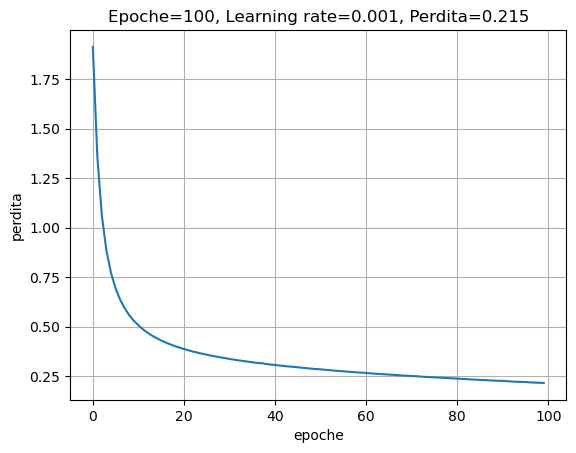

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.91      0.92      1032
           3       0.91      0.92      0.91      1010
           4       0.91      0.94      0.93       982
           5       0.91      0.88      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.91      0.88      0.89       974
           9       0.91      0.90      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [25]:
inner_size = 256
model = nn.Sequential(
    nn.Linear(784, inner_size),
    nn.Tanh(),
    nn.Linear(inner_size, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model)

**Analisi**

Tramite un layer in più con una funzione di attivazione non lineare otteniamo:
- La migliore accuracy misurata fino a questo momento.
- La perdita finale è leggermente più alta del caso migliore precedente. Probabilmente però con un numero più altro di iterazioni si osserverebbe una perdita migliore.
- Una discesa del grafico ripida, quindi il modello ha ancora molto da imparare.

In questo modello un problema è l'utilizzo di `Tanh()` come funzione di attivazione; questa infatti è saturante è porta al problema del *Vanishing gradients*. Funzioni di questo tipo sono poco sensibili al variare dell'activation input, in quanto tendono a portalo ad un valore massimo costante.



  0%|          | 0/100 [00:00<?, ?it/s]

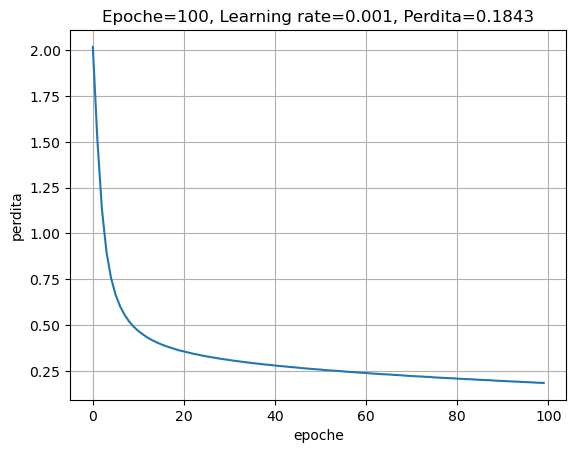

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.91      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.92      0.94      0.93       982
           5       0.93      0.89      0.91       892
           6       0.94      0.96      0.95       958
           7       0.94      0.93      0.93      1028
           8       0.92      0.88      0.90       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



  0%|          | 0/300 [00:00<?, ?it/s]

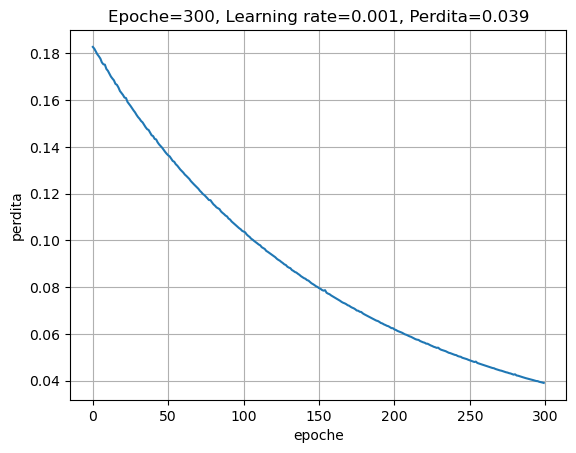

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.96      0.95      1010
           4       0.95      0.96      0.95       982
           5       0.95      0.92      0.94       892
           6       0.96      0.96      0.96       958
           7       0.95      0.95      0.95      1028
           8       0.94      0.93      0.93       974
           9       0.94      0.94      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [26]:
inner_size = 256
model = nn.Sequential(
    nn.Linear(784, inner_size),
    nn.ReLU(),
    nn.Linear(inner_size, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model)
model_multi_layer(model=model, epoche=300)

**Analisi**

Osserviamo quindi il comportamento di un'altra funzione non saturante come `ReLU()` con lo stesso numero di epoche e con più epoche:
- Con lo stesso numero di epoche:
    - L'accuracy non è migliorara ma le accuracy medie si.
    - La perdita è decisamente più bassa rispetto al caso precedente.
    - Osserviamo inoltre che il grafico della funzione sta ancora scendendo e quindi il modello sta ancora imparando.
- Aumentando il numero di epoche a *300* si osserva un notevole incremento dell'accuracy e una perdita finale più bassa. Inoltre la curva del grafico sta scendendo notevolmente e quindi probabilmente aumentando ancora il nunmero delle epoche si otterebbero risultati ancora migliori.

  0%|          | 0/100 [00:00<?, ?it/s]

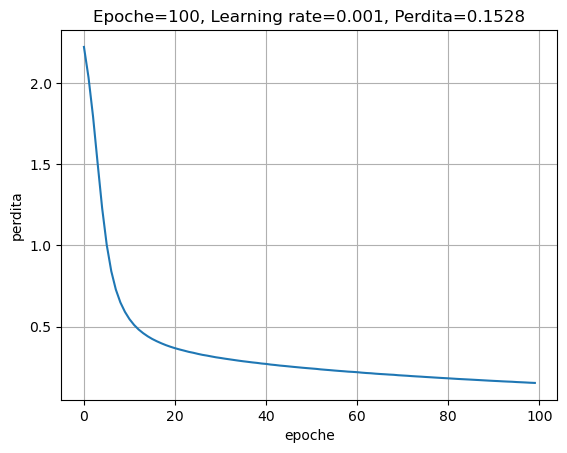

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.94      0.93      1032
           3       0.91      0.93      0.92      1010
           4       0.92      0.94      0.93       982
           5       0.93      0.88      0.91       892
           6       0.95      0.96      0.95       958
           7       0.94      0.93      0.94      1028
           8       0.92      0.90      0.91       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



  0%|          | 0/300 [00:00<?, ?it/s]

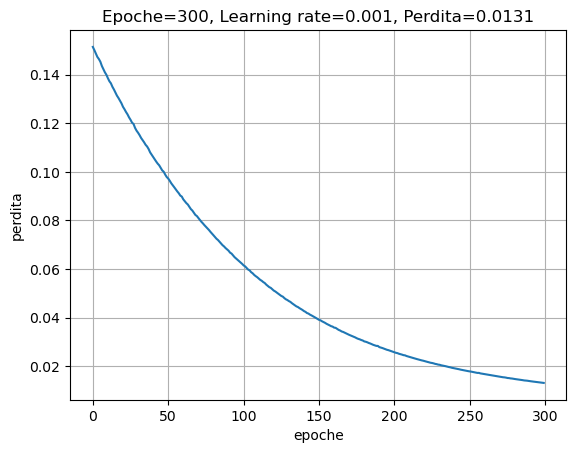

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.95      0.95      0.95      1010
           4       0.95      0.95      0.95       982
           5       0.95      0.93      0.94       892
           6       0.95      0.96      0.95       958
           7       0.96      0.96      0.96      1028
           8       0.95      0.93      0.94       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



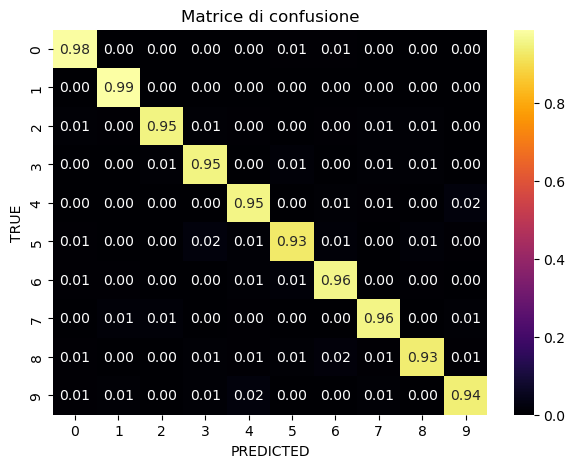

In [27]:
model = nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model)
model_multi_layer(model=model, epoche=300, conf_matrix=True)

**Analisi**

Costruendo una rete con la forma di due trapezzi uniti sulla base maggiore (qualcosa di simile alla prima immagine in [questo](https://kritikalsolutions.com/different-types-of-neural-networks-in-deep-learning/) articolo) e eseguendo 300 eopoche si ottiene un miglioramento rispetto alla rete costituita da un solo layer interno: l'accuracy la perdita finale sono le migliori registrate fino a questo momento.

**Analisi**

Vediamo ora cosa succede se utiliziamo come `torch.optim.Adam` (Adaptive Moment Estimation) come metodo di ottimizzazione.\
Considereremo tutti e tre i tipi di modelli costruiti precedentemente.

  0%|          | 0/100 [00:00<?, ?it/s]

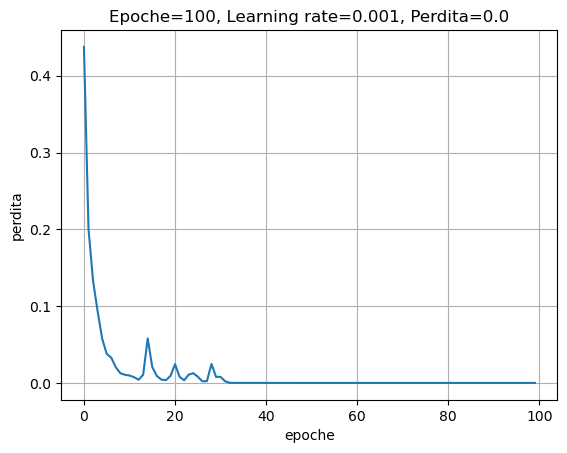

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [28]:
inner_size = 256
model = nn.Sequential(
    nn.Linear(784, inner_size),
    nn.ReLU(),
    nn.Linear(inner_size, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model, adam=True)

**Analisi**

Rispetto allo stesso modello (in termini di complessità e di struttura) che usa SGD si hanno risultati interessanti:
- L'accuracy è notevolmente migliorata.
- La perdita è zero.

Il comportamento che si osserva però ha dei problemi: la convergenza è molto veloce e questo fa pensare che il learning rate sia troppo alto.

  0%|          | 0/100 [00:00<?, ?it/s]

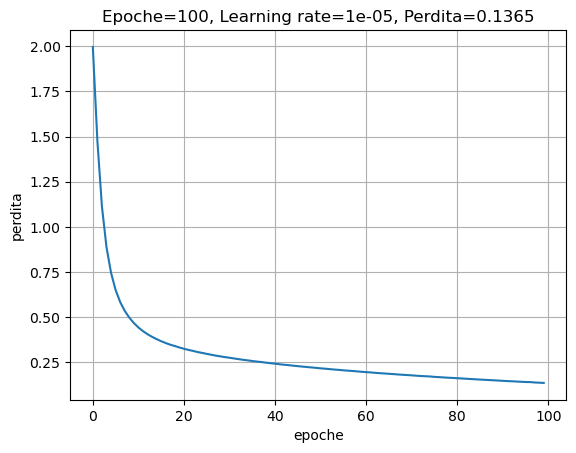

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.96      0.99      0.97      1135
           2       0.95      0.93      0.94      1032
           3       0.92      0.93      0.93      1010
           4       0.93      0.95      0.94       982
           5       0.92      0.91      0.91       892
           6       0.95      0.95      0.95       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.90      0.91       974
           9       0.93      0.91      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [29]:
inner_size = 256
model = nn.Sequential(
    nn.Linear(784, inner_size),
    nn.ReLU(),
    nn.Linear(inner_size, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model, lr=1e-5, adam=True)

**Analisi**

Rispetto al caso precedente vediamo se otteniamo un comportamento migliore riducendo il learning rate (adesso *1e-5*).\
Osserviamo che il processo diventa molto più stabile. Inoltre rispetto allo stesso modello che sua SGD ottiene risutlati migliori sia intermini di accuracy che di perdita finale.

  0%|          | 0/100 [00:00<?, ?it/s]

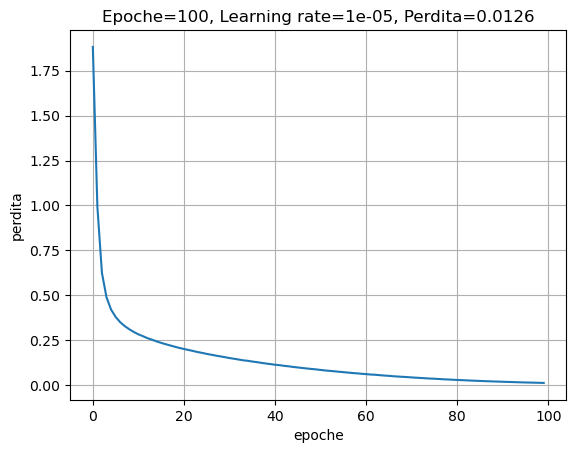

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.96      0.94      0.95      1032
           3       0.94      0.95      0.95      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.94      0.95       892
           6       0.95      0.97      0.96       958
           7       0.97      0.95      0.96      1028
           8       0.94      0.95      0.95       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



  0%|          | 0/300 [00:00<?, ?it/s]

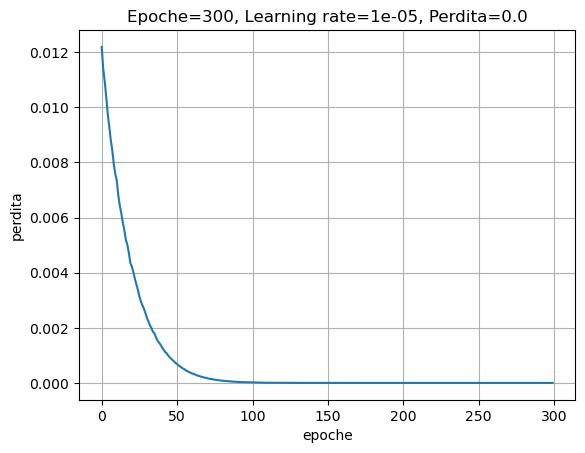

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.94      0.95       892
           6       0.96      0.97      0.96       958
           7       0.95      0.96      0.96      1028
           8       0.95      0.93      0.94       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



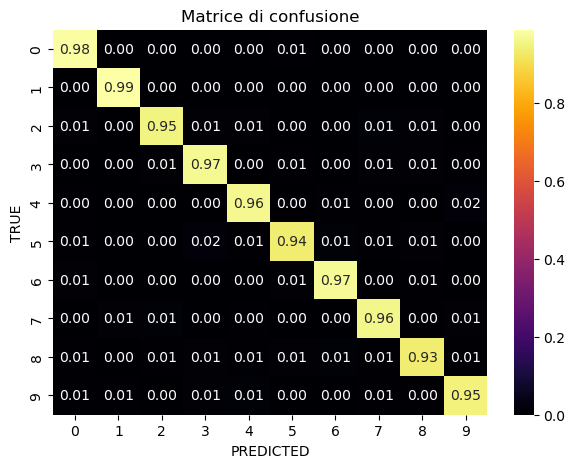

In [30]:
model = nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model, lr=1e-5, adam=True)
model_multi_layer(model=model, lr=1e-5, epoche=300, conf_matrix=True, adam=True)

**Analisi**

Vediamo il comportamento dell'*Adaptive Moment Estimation* su un modello più complesso; anche in questo caso utiliziamo un learning rate più basso per avere un processo più stabile.\
Con 100 epoche si migliora l'accuracy rispetto al caso precedente ma non si supera quella dello stesso modello attenuta con `SGD`. Aumentano il numero delle epoche non si migliora l'accuracy ma si arriva ad una convergenza totale.

In generale sembra che `Adam` converga più velocemente di `SGD`; probabilmente usando l'intero dataset e non solo 1/6 (10000/60000) allora sarebbe molto più conveniente usare `Adam`.


**Analisi**

Come nel blocco precedente ho stampato le matrici di confusione nel migliore e nel peggiore dei casi.

  0%|          | 0/1000 [00:00<?, ?it/s]

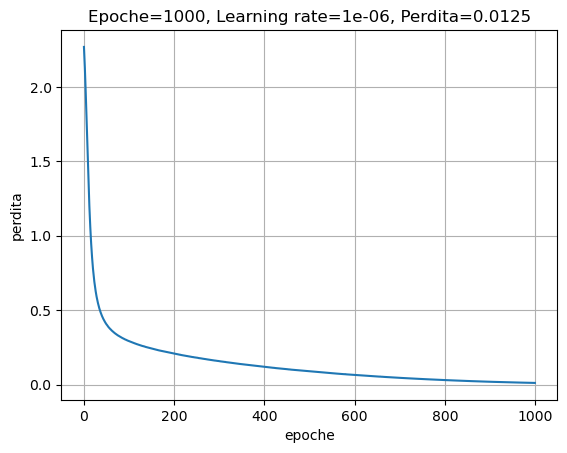

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.99      0.98      1135
           2       0.97      0.95      0.96      1032
           3       0.95      0.96      0.96      1010
           4       0.95      0.96      0.95       982
           5       0.96      0.93      0.95       892
           6       0.95      0.97      0.96       958
           7       0.95      0.96      0.95      1028
           8       0.95      0.94      0.94       974
           9       0.95      0.94      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



In [31]:
model = nn.Sequential(
    nn.Linear(784, 1024),
    nn.ReLU(),
    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1))

model_multi_layer(model=model, lr=1e-6, epoche=1000, adam=True)

**Analisi**

Ho provato a battere la precisione ottenuta fino a questo punto ora usando lo stesso modello, abbassando di un ordine di grandezza il learning rate, usando `Adam` e eseguendo 1000 (forse troppe visto quando ci ha messo ad eseguire) epoche.

Si osserva che l'accuracy e la loss finale sono le stesse ottenute con `SGD`. Probabilmente arrivati a questo punto sia il metodo di ottimizzazione sia il numero di epoche non incide più di molto sul risultato finale.